# Assignment 1 Group B5

### Exploratory Question:
##### Is domestic unrest associated with distinct rheotoric patterns in UNGC speeches? Specifically, do countries experiencing high unrest employ different rhetorical patterns compared to stable countries, and how are these rhetorical differences related to levels of national happiness?

### Predictive Question:
#####  Can the features extracted from UNGA speeches, be used to forecast the likelihood of domestic unrest in the following year?

In [58]:
from pathlib import Path
import pandas as pd
from glob import glob
import os
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [59]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('words')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ileshyadav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ileshyadav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ileshyadav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ileshyadav/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# a) Data Collection and Preparation

## Importing UNGC Speech Data
This code loops from the folders of TXT and takes every .txt file that does not start with ._ which contain the speeches per country per year. These are then added to a dataframe, storing the year, country code and the speech

In [60]:
path = Path("/Users/ileshyadav/Desktop/FDS_ASSIGNMENT1-main/TXT")

name_text = []
for folder in path.iterdir():
    if folder.is_dir():
        files = [f for f in folder.glob("*.txt") if not f.name.startswith("._")]

        for file in files:
            name = file.name
            text = file.read_text(encoding="utf-8")
            
            name_text.append({
                        "country": name[:3],
                        "year": name[-8:-4],
                        "speech": text
                    })
    
df = pd.DataFrame(name_text)

df.head(5)

,country,year,speech
0,BEL,1950,Never before have men throughout the world mor...
1,BLR,1950,It is now five years since the United Nations ...
2,FRA,1950,"At the conclusion of this general discussion, ..."
3,PAK,1950,May I be permitted to congratulate the General...
4,TUR,1950,The era inaugurated by the creation of the Uni...


In [61]:
df.tail(5)

,country,year,speech
10948,LIE,2014,This has been an \nenormously difficult year f...
10949,AZE,2014,"At the outset, \nI would like to congratulate ..."
10950,GRC,2014,This sixty-ninth session of the General Assemb...
10951,ISL,2014,Next year we will \ncelebrate the seventieth a...
10952,HUN,2014,"“If you seek peace, prepare for war.” Those ar..."


## Punctuation - Stopwords - Tokenizing
The following code removes all punctuation from the texts, it also tokenizes the string (returns a list of each word separately as a string) and removes stopwords from it and non alphabetical tokens

https://www.geeksforgeeks.org/nlp/removing-stop-words-nltk-python/ 

https://www.geeksforgeeks.org/python/python-remove-punctuation-from-string/

We also remove words that are related to countries as can be found in the CSV file

https://en.wikipedia.org/wiki/List_of_adjectival_and_demonymic_forms_for_countries_and_nations

In [62]:
countries_df = pd.read_csv("List_of_adjectival_and_demonymic_forms_for_countries_and_nations_1.csv")
countries_flat = countries_df.values.ravel().tolist()
countries = []

def split_small_capital(text):
    split = re.sub(r'([a-z])([A-Z])', r'\1 \2', text).split()
    countries.extend(split)

for country_adj in countries_flat: split_small_capital(country_adj)

countries = [country.lower()for country in countries]

In [63]:
stop_words = set(stopwords.words('english'))
english_vocab = set(words.words())

df_tokenize = df.copy()

def punc_stop_token_english(speech: str):
    # Remove punctuation
    speech_no_punctuation = re.sub(r'[^\w\s]', '', speech)
    
    # Tokenize and lowercase
    tokens = word_tokenize(speech_no_punctuation.lower())
    
    # POS tagging
    pos_tags = pos_tag(tokens)
    
    # Keep only words that:
    # - are alphabetic
    # - are not stopwords
    # - are not proper nouns (NNP, NNPS)
    # - are in English vocabulary
    new_speech = [
        word for word, tag in pos_tags
        if (word.isalpha()) 
        and (word not in stop_words)
        and (tag not in ['NNP', 'NNPS'])
        and (word in english_vocab)
    ]
    
    return new_speech

# Apply to our object dataframe
df_tokenize['speech_token'] = df_tokenize['speech'].apply(punc_stop_token_english)
df_tokenize.head(5)

,country,year,speech,speech_token
0,BEL,1950,Never before have men throughout the world mor...,"[never, men, throughout, world, fervently, una..."
1,BLR,1950,It is now five years since the United Nations ...,"[five, since, united, charter, laid, fundament..."
2,FRA,1950,"At the conclusion of this general discussion, ...","[conclusion, general, discussion, much, eloque..."
3,PAK,1950,May I be permitted to congratulate the General...,"[may, permitted, congratulate, general, assemb..."
4,TUR,1950,The era inaugurated by the creation of the Uni...,"[era, creation, united, one, critical, tension..."


## Word Frequency
Unigrams (e.g., “peace”, “war”, “growth”) capture general rhetoric.
Bigrams (e.g., “human rights”, “climate change”, “economic development”) capture rhetorical style and key phrases.
Using both gives a richer feature space , creating more nuance when comparing countries with high vs. low polarisation

/var/folders/gr/s9lqsxxj3wg19mz80z916kcm0000gn/T/ipykernel_11509/732451350.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/gr/s9lqsxxj3wg19mz80z916kcm0000gn/T/ipykernel_11509/732451350.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


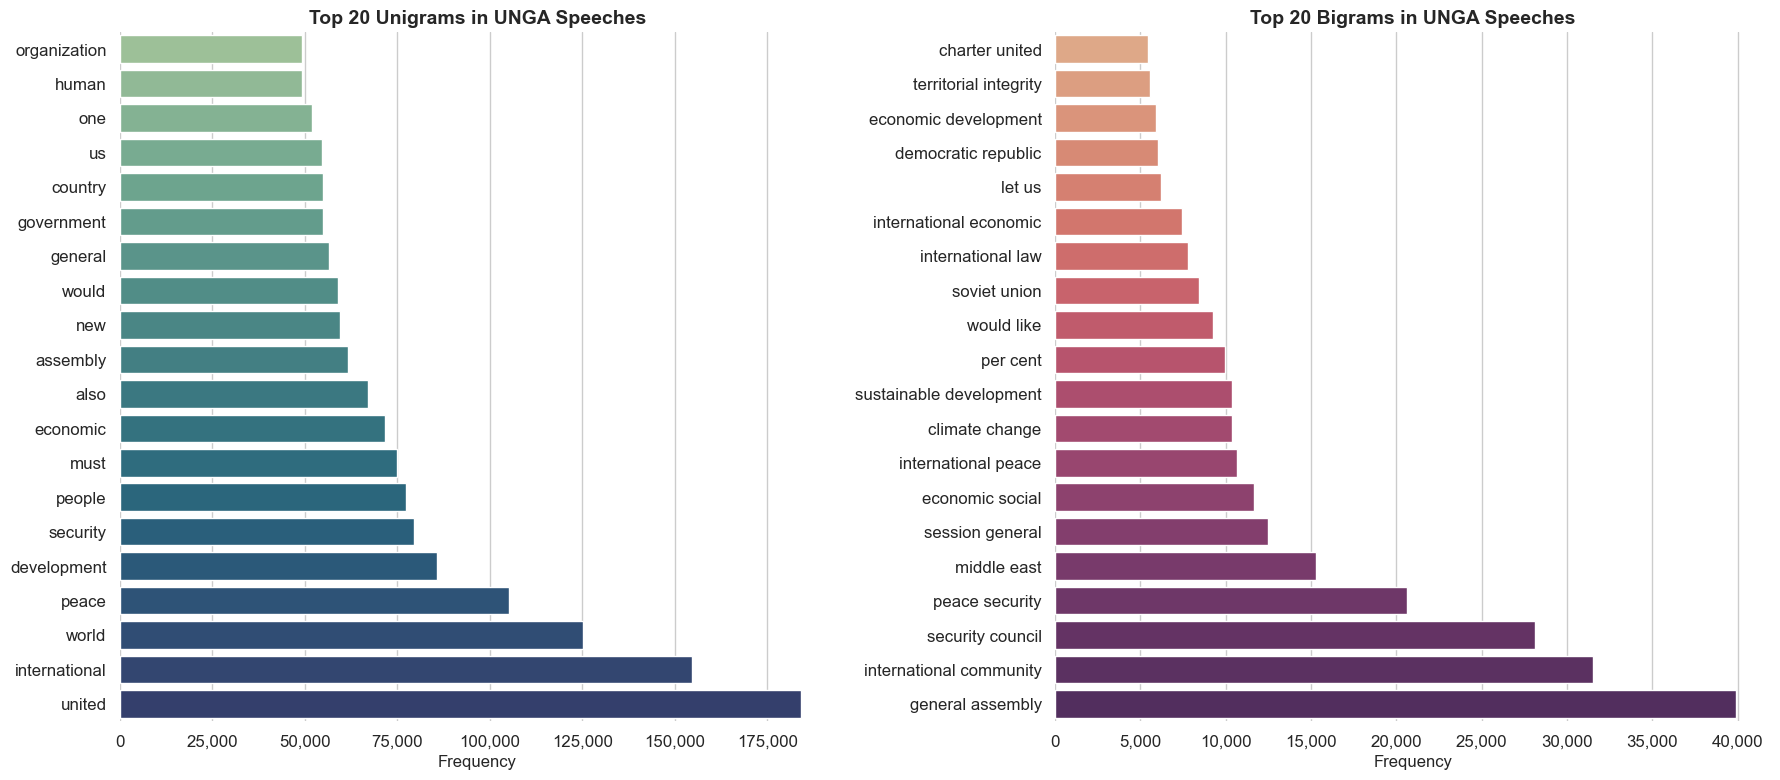

In [64]:
from collections import Counter
from nltk import ngrams
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
# Unigram counts
all_unigrams = []
for tokens in df_tokenize["speech_token"]:
    if isinstance(tokens, list):
        all_unigrams.extend(tokens)

unigram_counts = Counter(all_unigrams)
unigram_df = pd.DataFrame(unigram_counts.most_common(20), columns=["unigram", "count"])

# Bigram counts 
all_bigrams = []
for tokens in df_tokenize["speech_token"]:   
    if isinstance(tokens, list):
        all_bigrams.extend(list(ngrams(tokens, 2)))

bigram_counts = Counter(all_bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(20), columns=["bigram", "count"])
bigram_df["bigram"] = bigram_df["bigram"].apply(lambda x: " ".join(x))

# Plot side by side 
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=False)

# Unigrams
sns.barplot(
    data=unigram_df.sort_values("count", ascending=True),
    y="unigram", x="count",
    palette="crest", ax=axes[0]
)
axes[0].set_title("Top 20 Unigrams in UNGA Speeches", fontsize=14, weight="bold")
axes[0].set_xlabel("Frequency", fontsize=12)
axes[0].set_ylabel("")
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Bigrams
sns.barplot(
    data=bigram_df.sort_values("count", ascending=True),
    y="bigram", x="count",
    palette="flare", ax=axes[1]
)
axes[1].set_title("Top 20 Bigrams in UNGA Speeches", fontsize=14, weight="bold")
axes[1].set_xlabel("Frequency", fontsize=12)
axes[1].set_ylabel("")
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# remove spines
for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)

plt.tight_layout()
plt.show()

## Import Political Polarization Dataset 

In [65]:
polarization_df = pd.read_csv("political-polarization-score.csv")
polarization_df.head()

polarization_df.columns = polarization_df.columns.str.lower()

bounds = [ -3, -1, 1, 3]

labels = [
    "Stable",
    "Neutral",
    "Polarized"
]

polarization_df["polarization label"] = pd.cut(
    polarization_df["political polarization score (central estimate)"],
    bins=bounds,
    labels=labels,
    include_lowest=True,
    right=False
)
polarization_df = polarization_df.rename(columns={"code": "country"})


polarization_df

,entity,country,year,political polarization score (central estimate),polarization label
0,Afghanistan,AFG,1992,2.775,Polarized
1,Afghanistan,AFG,1993,2.775,Polarized
2,Afghanistan,AFG,1994,2.775,Polarized
3,Afghanistan,AFG,1995,2.775,Polarized
4,Afghanistan,AFG,1996,2.775,Polarized
...,...,...,...,...,...
22674,Zimbabwe,ZWE,2020,2.499,Polarized
22675,Zimbabwe,ZWE,2021,2.066,Polarized
22676,Zimbabwe,ZWE,2022,1.551,Polarized
22677,Zimbabwe,ZWE,2023,1.984,Polarized


/var/folders/gr/s9lqsxxj3wg19mz80z916kcm0000gn/T/ipykernel_11509/1193577288.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = (pol.groupby(["decade", "polarization label"])["country"]


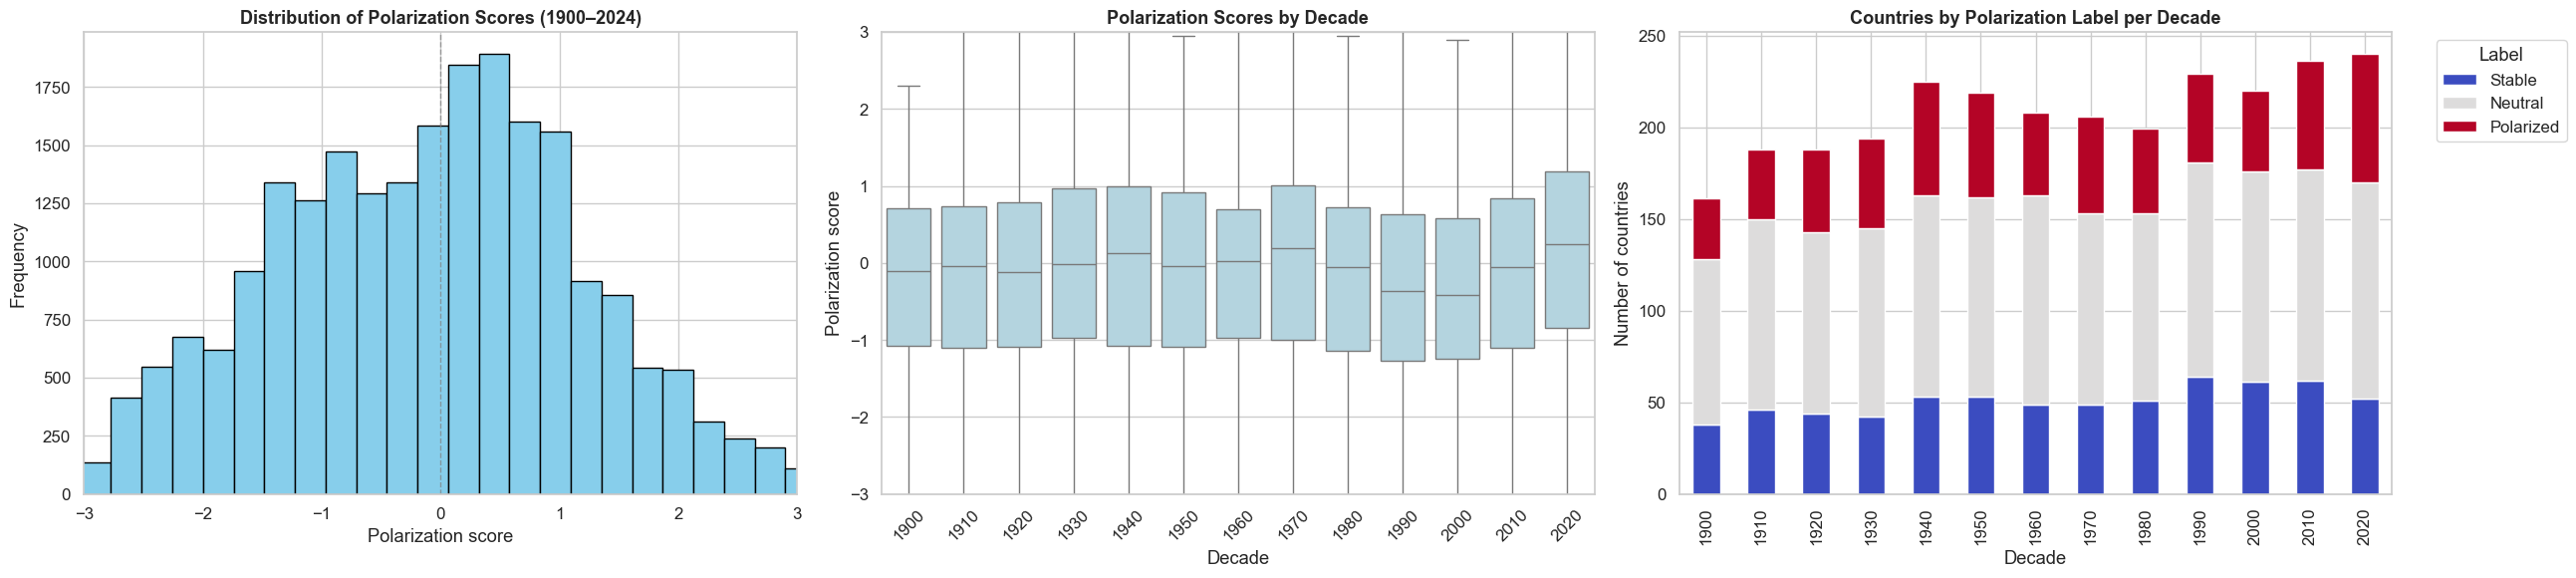

In [66]:
# Clean & prep
pol = polarization_df.copy()
pol = pol.dropna(subset=["political polarization score (central estimate)"])
pol["decade"] = (pol["year"] // 10) * 10
pol["decade"] = pol["decade"].astype(int)

# Count number of countries per label per decade
counts = (pol.groupby(["decade", "polarization label"])["country"]
            .nunique()
            .reset_index(name="num_countries"))

# Pivot for stacked bar plotting
counts_pivot = counts.pivot(index="decade", columns="polarization label", values="num_countries").fillna(0)

# Create subplots: Histogram + Boxplot + Stacked Bar
fig, axes = plt.subplots(1, 3, figsize=(26, 6))

# 1) Histogram [-3, 3]
axes[0].hist(
    pol["political polarization score (central estimate)"],
    bins=30, edgecolor="black", color="skyblue"
)
axes[0].set_title("Distribution of Polarization Scores (1900–2024)", fontsize=13, weight="bold")
axes[0].set_xlabel("Polarization score")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(-3, 3)
axes[0].axvline(0, ls="--", lw=1, color="gray", alpha=0.7)

# 2) Boxplot by decade 
sns.boxplot(
    data=pol,
    x="decade",
    y="political polarization score (central estimate)",
    color="lightblue",
    ax=axes[1]
)
axes[1].set_title("Polarization Scores by Decade", fontsize=13, weight="bold")
axes[1].set_xlabel("Decade")
axes[1].set_ylabel("Polarization score")
axes[1].set_ylim(-3, 3)
axes[1].tick_params(axis='x', rotation=45)

# 3) Stacked bar: country counts by label & decade
counts_pivot.plot(
    kind="bar",
    stacked=True,
    ax=axes[2],
    colormap="coolwarm"
)
axes[2].set_title("Countries by Polarization Label per Decade", fontsize=13, weight="bold")
axes[2].set_xlabel("Decade")
axes[2].set_ylabel("Number of countries")
axes[2].legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")

# Final layout
plt.tight_layout()
plt.show()


## Merge Speeches with Polarisation Dataset

In [67]:
for df in (df_tokenize, polarization_df):
    df['country'] = df['country'].astype(str).str.strip()
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

bad_tf = df_tokenize[df_tokenize['year'].isna()]
bad_pol = polarization_df[polarization_df['year'].isna()]

##merge on right so that we filter out UN countries with missing polarisation scores
merged_df = df_tokenize.merge(
    polarization_df,
    how='right',
    on=['country', 'year']
)
merged_df = merged_df.drop(columns=['entity'])
merged_df = merged_df.dropna()
merged_df

,country,year,speech,speech_token,political polarization score (central estimate),polarization label
0,AFG,1992,I shall read out the following statement\non b...,"[shall, read, following, statement, behalf, de...",2.775,Polarized
1,AFG,1993,"Permit me, first of all, to\ncongratulate Amba...","[permit, first, congratulate, ambassador, unan...",2.775,Polarized
2,AFG,1994,It gives me great\npleasure to convey on behal...,"[great, pleasure, convey, behalf, state, warm,...",2.775,Polarized
3,AFG,1995,On the eve of the\nfiftieth anniversary of the...,"[eve, fiftieth, anniversary, united, hearts, f...",2.775,Polarized
4,AFG,1996,"﻿At the outset, allow\nme, Sir, to express my ...","[outset, allow, sir, express, upon, election, ...",2.775,Polarized
...,...,...,...,...,...,...
22674,ZWE,2020,"Your Excellency, Ambassador Volkan Bozkir, Pre...","[excellency, ambassador, president, session, u...",2.499,Polarized
22675,ZWE,2021,"Your Excellency Abdulla Shahid, President of t...","[excellency, president, session, general, asse...",2.066,Polarized
22676,ZWE,2022,It is my singular honour to deliver this state...,"[singular, deliver, statement, assembly, allow...",1.551,Polarized
22677,ZWE,2023,I wish to congratulate Mr. Dennis Francis on h...,"[wish, congratulate, election, president, gene...",1.984,Polarized


# b) Data Analysis and Visualisation

## Exploring polarization intensity per country over the years 

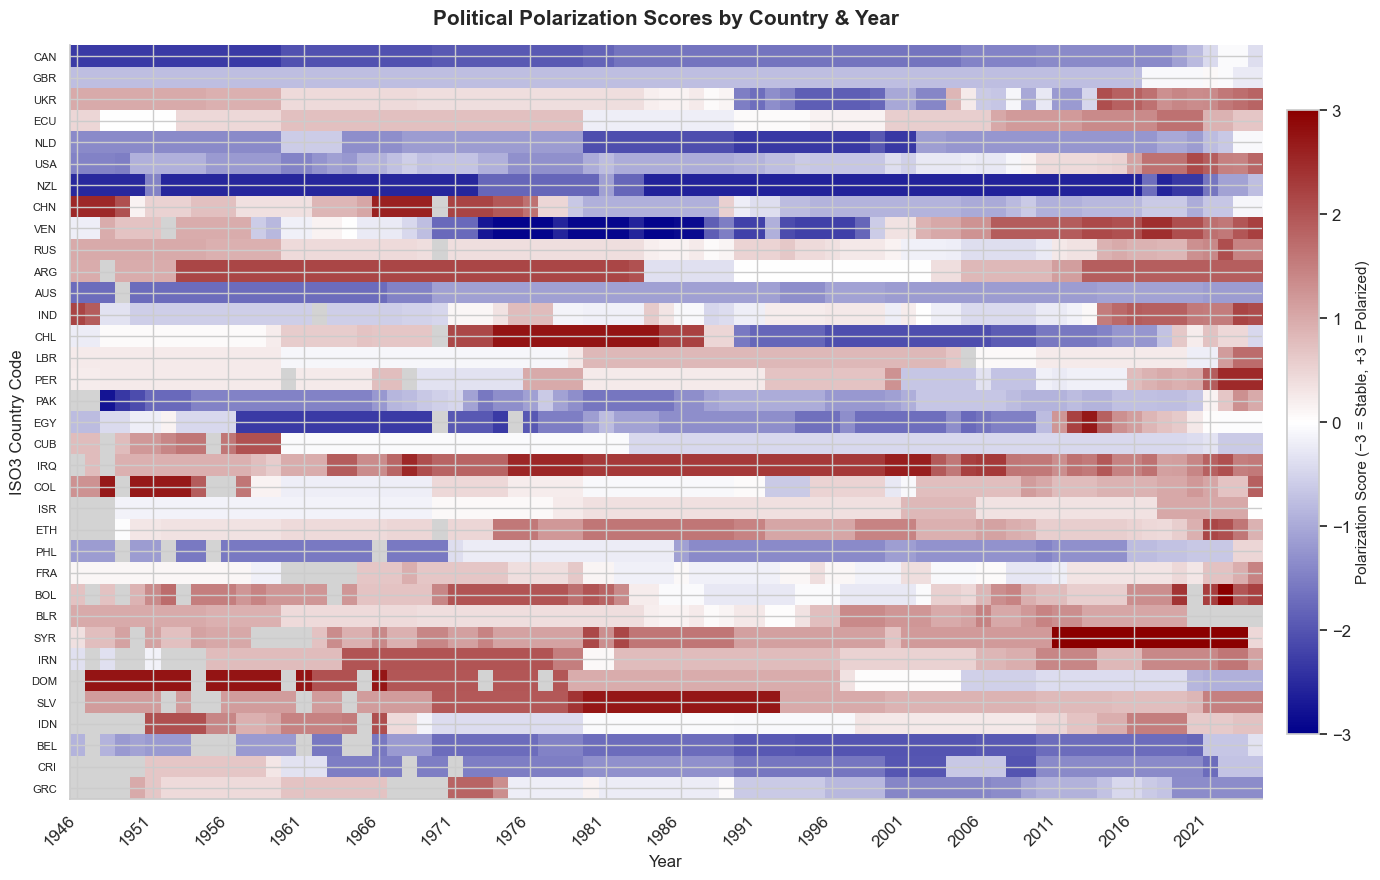

In [68]:
# Political polarization scores by country & year 
from matplotlib.colors import LinearSegmentedColormap

# Use all rows (keep NaNs for visualization)
df_all = merged_df.copy()

# Pick top N countries by number of available scores
topN = 35
top_codes = (df_all.groupby("country")["political polarization score (central estimate)"]
             .count().sort_values(ascending=False).head(topN).index.tolist())

sub = df_all[df_all["country"].isin(top_codes)]
years = np.arange(sub["year"].min(), sub["year"].max() + 1)

# Build matrix: countries × years
M = np.full((len(top_codes), len(years)), np.nan)
country_index = {c: i for i, c in enumerate(top_codes)}
year_index    = {y: i for i, y in enumerate(years)}

for _, r in sub.iterrows():
    i = country_index[r["country"]]
    j = year_index.get(r["year"])
    if j is not None:
        M[i, j] = r["political polarization score (central estimate)"]

# Mask NaNs so they can be styled separately
masked_M = np.ma.masked_invalid(M)

# Format
colors = ["darkblue", "white", "darkred"]
cmap = LinearSegmentedColormap.from_list("custom_div", colors, N=256)
cmap.set_bad(color="lightgray")  # missing values as light gray

# Plot
fig, ax = plt.subplots(figsize=(14, 9))

im = ax.imshow(
    masked_M,
    aspect="auto",
    interpolation="nearest",
    cmap=cmap,
    vmin=-3, vmax=3  # enforce theoretical score range
)

# Axis formatting
ax.set_yticks(range(len(top_codes)))
ax.set_yticklabels(top_codes, fontsize=8)

step = max(1, len(years)//15)
ax.set_xticks(range(0, len(years), step))
ax.set_xticklabels(years[::step], rotation=45, ha="right")

ax.set_title("Political Polarization Scores by Country & Year", fontsize=15, weight="bold", pad=15)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("ISO3 Country Code", fontsize=12)

# Colorbar with clear labels
cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label("Polarization Score (−3 = Stable, +3 = Polarized)", fontsize=11)

# Styling
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


## Speech Style using TF-IDF 
The following code calculates the TF-IDF score for each word in every speech, this is then stored in the Dataframe as a list of pairs, containing (word, tf-idf score), sorted descendingly, so you get the higher TF-IDF scores first. 

It also considers bi-grams.

https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_tf_idf = merged_df.copy()

# Join tokens back into strings 
# we can also alternatively use df_tf_idf['speech_token'] = df_tf_idf['speech_token'].str.join(' '); however in order to avoid run-time errors , we use the lambda function
df_tf_idf['speech_token'] = df_tf_idf['speech_token'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else str(x)
)

speeches = df_tf_idf['speech_token']

# add n-grams (unigrams and bigrams) + frequency filters
tfidf_vector = TfidfVectorizer(
    ngram_range=(1, 2), # unigrams + bigrams
    min_df=2,
    max_df=0.9
)

tf_idf_matrix  = tfidf_vector.fit_transform(speeches)

print(tf_idf_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13836567 stored elements and shape (9696, 1028993)>
  Coords	Values
  (0, 819887)	0.0074219713171418044
  (0, 728557)	0.01482696235448589
  (0, 357721)	0.007387084778089115
  (0, 864948)	0.008236346714830745
  (0, 90889)	0.013649652279371274
  (0, 237610)	0.016889448609696687
  (0, 694595)	0.009689461805384889
  (0, 565212)	0.01596258230315036
  (0, 361125)	0.005470701726811676
  (0, 36264)	0.006691010464089475
  (0, 330095)	0.01752528166100394
  (0, 287608)	0.020510097487245128
  (0, 688966)	0.004322784078919977
  (0, 813983)	0.042504851737799616
  (0, 377301)	0.01704685231225514
  (0, 169018)	0.00894049713964286
  (0, 1013198)	0.008600640653976564
  (0, 1027308)	0.013670354059578695
  (0, 375849)	0.01065829249269085
  (0, 454623)	0.006305335504704927
  (0, 723879)	0.025144292399581474
  (0, 1008245)	0.023440486022671483
  (0, 409227)	0.011808986898740985
  (0, 845628)	0.025304983479014
  (0, 664821)	0.009425160438969148
  

In [70]:
feature_names = tfidf_vector.get_feature_names_out()

def matrix_to_tfidf_pairs(row):
    row_array = row.toarray().flatten()  
    word_tf_idf_pairs = [(word, score) for word, score in zip(feature_names, row_array) if score > 0]
    pairs_sorted = sorted(word_tf_idf_pairs, key=lambda x: x[1], reverse=True)
    return pairs_sorted

df_tf_idf['speech_score'] = [matrix_to_tfidf_pairs(tf_idf_matrix[i]) for i in range(tf_idf_matrix.shape[0])]

df_tf_idf[['country', 'year', 'speech_score']].head()

,country,year,speech_score
0,AFG,1992,"[(state, 0.14099743750757712), (former soviet,..."
1,AFG,1993,"[(land mines, 0.10607995265626893), (mines, 0...."
2,AFG,1994,"[(special mission, 0.14422080286204936), (poli..."
3,AFG,1995,"[(embassy, 0.15421482644007567), (grand nation..."
4,AFG,1996,"[(letter, 0.12682869050804077), (special missi..."


## Rhetorical Differences Between Stable and Unrest Countries  

In this section, we investigate whether countries experiencing higher domestic unrest (Polarized) use measurably different rhetoric in their UNGA speeches compared to politically stable countries.  

To do this, we:  
1. Split speeches into **Stable** vs **Unrest** groups based on the polarization label.  
2. Compute average TF-IDF scores for each word across the two groups.  
3. Identify and visualize the words that are most characteristic of **Unrest** versus **Stable** countries.  

This step directly addresses the **exploratory question** by highlighting how rhetoric differs between politically stable nations and those facing domestic unrest.  


##  Is domestic unrest associated with distinct rheotoric patterns in UNGC speeches? Specifically, do countries experiencing high unrest employ different rhetorical patterns compared to stable countries?

In [71]:
# Filtering relevant groups and creating group masks
keep = df_tf_idf['polarization label'].isin(["Stable", "Polarized"])
df_tf_idf_filtered = df_tf_idf.loc[keep].reset_index(drop=True)
tf_idf_matrix_filtered = tf_idf_matrix[keep.values]  # subset matrix to match

mask_unrest = df_tf_idf_filtered["polarization label"].eq("Polarized").values
mask_stable = df_tf_idf_filtered["polarization label"].eq("Stable").values

# Compute mean TF-IDF by group
mean_unrest = tf_idf_matrix_filtered[mask_unrest].mean(axis=0).A1
mean_stable = tf_idf_matrix_filtered[mask_stable].mean(axis=0).A1
delta = mean_unrest - mean_stable  # positive = unrest-leaning; delta shows which words/bigrams are more emphasized in polarized (unrest) vs stable contexts.

fn = np.array(feature_names)

# feature separation
is_bigram  = np.array([" " in t for t in fn])
is_unigram = ~is_bigram

def top_terms(delta_vec, feats, k=15, mask=None, reverse=False):
    idx = np.arange(len(delta_vec))
    if mask is not None: idx = idx[mask]
    order = idx[np.argsort(delta_vec[idx])]
    if not reverse: order = order[::-1]
    return [(feats[i], float(delta_vec[i])) for i in order[:k]]

The helper function top_terms() sorts by the largest differences in TF-IDF between groups.

- If delta > 0: word is emphasized more in polarized/unrest speeches.
- If delta < 0: word is emphasized more in stable speeches.

/var/folders/gr/s9lqsxxj3wg19mz80z916kcm0000gn/T/ipykernel_11509/2727722302.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/gr/s9lqsxxj3wg19mz80z916kcm0000gn/T/ipykernel_11509/2727722302.py:33: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/var/folders/gr/s9lqsxxj3wg19mz80z916kcm0000gn/T/ipykernel_11509/2727722302.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/gr/s9lqsxxj3wg19mz80z916kcm0000gn/T/ipykernel_11509/2727722302.py:33: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
 

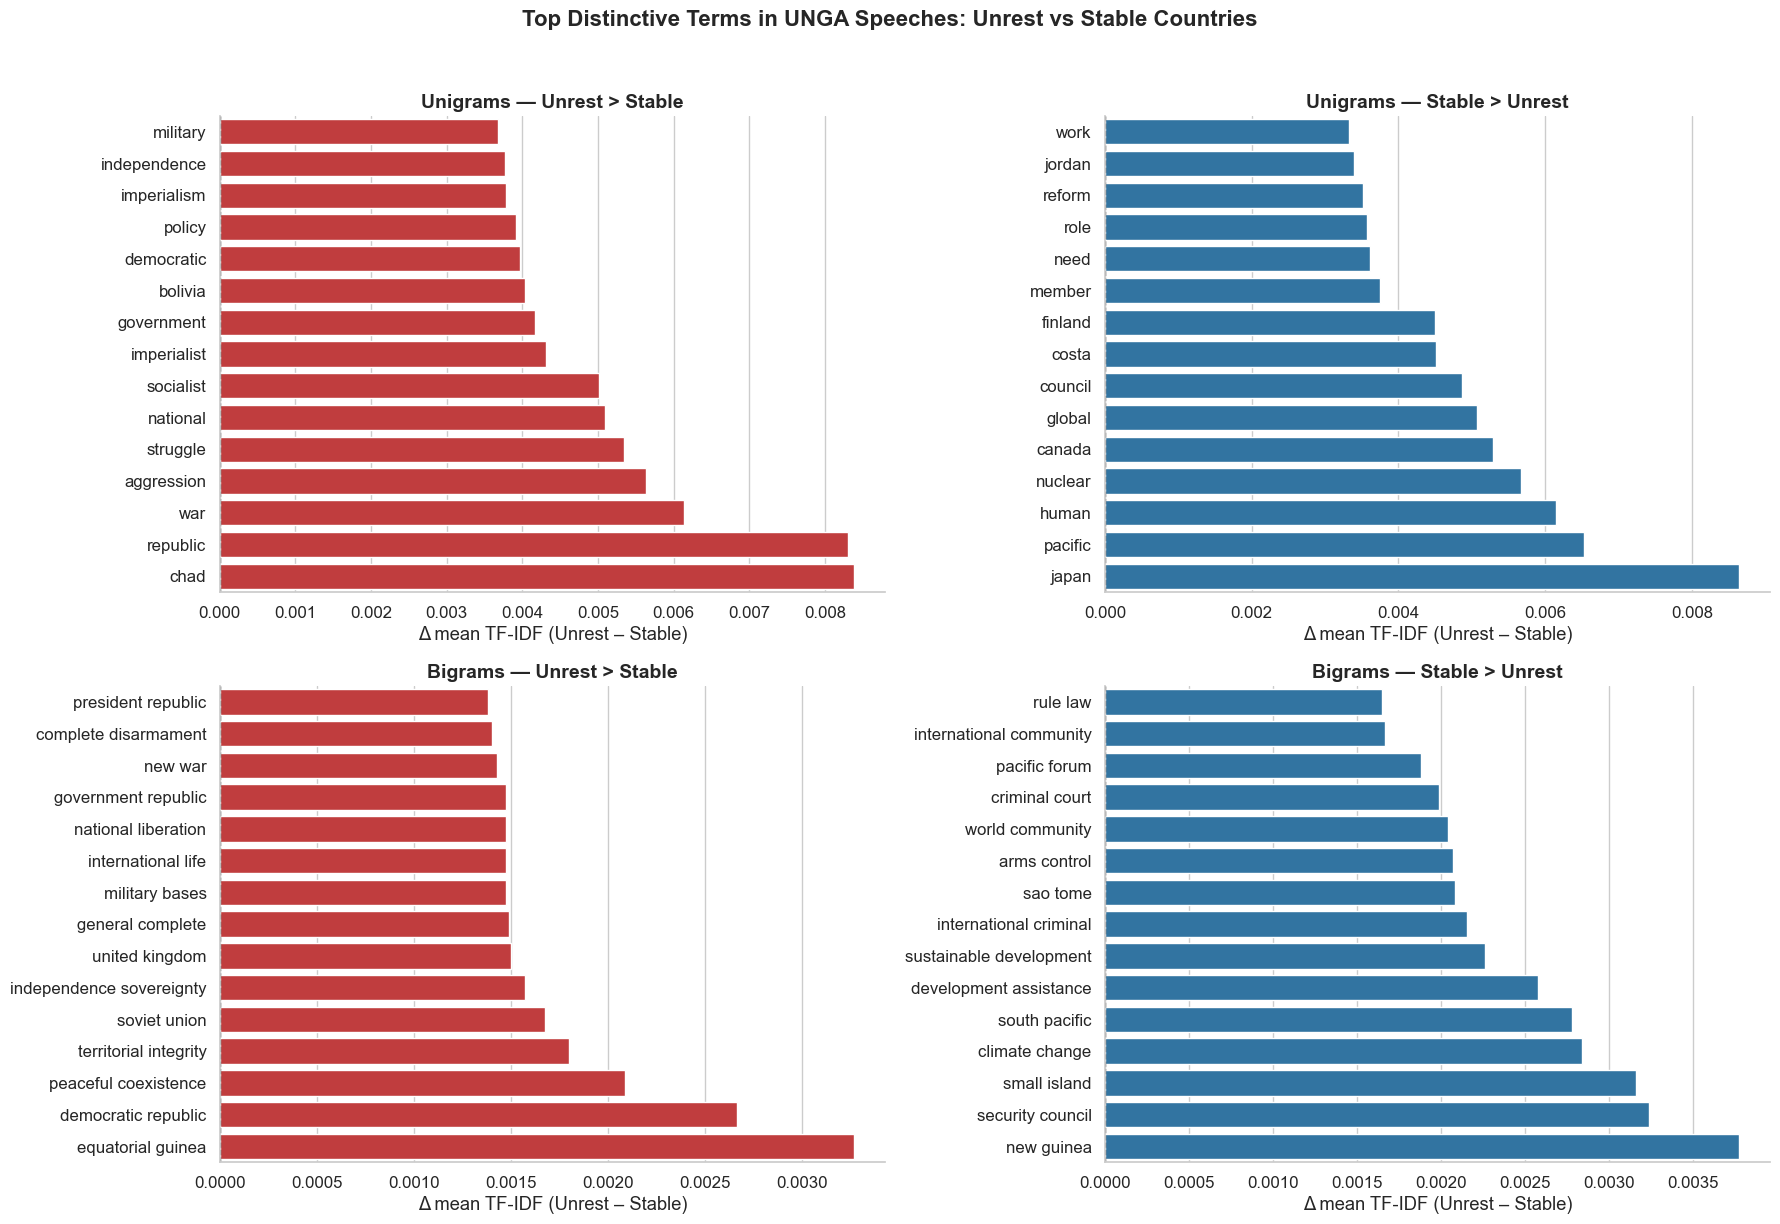

In [72]:
# Barplots: Top delta TF-IDF Terms (Unrest vs Stable) 
import seaborn as sns
import matplotlib.pyplot as plt

# Build DataFrames of the top Δ terms for plotting
def top_df(delta_vec, feats, k=15, mask=None, sign=+1, tag="Unrest"):
    idx = np.arange(len(delta_vec))
    if mask is not None:
        idx = idx[mask]
    # sign=+1 -> top Unrest (largest positive deltas)
    # sign=-1 -> top Stable (largest negative deltas)
    order = idx[np.argsort(sign * delta_vec[idx])][::-1][:k]
    return pd.DataFrame({
        "term": feats[order],
        "delta": delta_vec[order] * sign,   # positive values for plotting
        "side": tag
    })

top_uni_unrest = top_df(delta, fn, k=15, mask=is_unigram, sign=+1, tag="Unrest")
top_uni_stable = top_df(delta, fn, k=15, mask=is_unigram, sign=-1, tag="Stable")
top_bi_unrest  = top_df(delta, fn, k=15, mask=is_bigram,  sign=+1, tag="Unrest")
top_bi_stable  = top_df(delta, fn, k=15, mask=is_bigram,  sign=-1, tag="Stable")

# Set style
sns.set_theme(style="whitegrid", font_scale=1.1)

# Plot 2×2 barh
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

def barh(ax, df, title, color):
    df_plot = df.sort_values("delta") # ascending for clean ordering
    sns.barplot(
        data=df_plot,
        x="delta", y="term",
        palette=[color],
        ax=ax
    )
    ax.axvline(0, color="black", lw=1, ls="--", alpha=0.7) # reference line
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("Δ mean TF-IDF (Unrest – Stable)")
    ax.set_ylabel("")
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# Apply plotting function with distinct colors
barh(axes[0], top_uni_unrest, "Unigrams — Unrest > Stable", "#d62728") # red
barh(axes[1], top_uni_stable, "Unigrams — Stable > Unrest", "#1f77b4") # blue
barh(axes[2], top_bi_unrest,  "Bigrams — Unrest > Stable", "#d62728")  
barh(axes[3], top_bi_stable,  "Bigrams — Stable > Unrest", "#1f77b4")  

plt.suptitle("Top Distinctive Terms in UNGA Speeches: Unrest vs Stable Countries", 
             fontsize=16, weight="bold", y=1.02)

plt.tight_layout()
plt.show()


Each barplot compares **average TF-IDF scores** of words/phrases between two groups of countries:
- **Polarized (Unrest)** countries  
- **Stable** countries  

For each unigram (single word) or bigram (two-word phrase), we compute: Δ = {mean TF-IDF in Unrest speeches} - {mean TF-IDF in Stable speeches}
 

### Interpreting each subplot

**Unigrams — Unrest > Stable**  
- Shows the top single words where Δ is **positive**.  
- These words are used relatively more often (or emphasized more strongly) in speeches by **polarized/unrest countries** compared to stable countries.  

**Unigrams — Stable > Unrest**  
- Shows the top single words where Δ is **negative** (but flipped to positive for visualization).  
- These words are used relatively more often in speeches by **stable countries** compared to unrest countries.  

**Bigrams — Unrest > Stable**  
- Same as above, but for **two-word phrases**.  
- Tells you which bigrams are most distinctive of **polarized contexts**.  

**Bigrams — Stable > Unrest**  
- Same as above, but for bigrams.  
- Tells you which bigrams are most distinctive of **stable contexts**.  


## Performing statistical test to prove our evidence-backed hypothesis

In [73]:
from scipy.stats import mannwhitneyu

fn = np.array(feature_names)
X = tf_idf_matrix_filtered # sparse csr

# pick features with largest absolute deltas
mean_unrest = X[mask_unrest].mean(axis=0).A1
mean_stable = X[mask_stable].mean(axis=0).A1
delta = mean_unrest - mean_stable
k = min(200, len(delta))
top_idx = np.argsort(np.abs(delta))[::-1][:k]

rows = []
Xu = X[mask_unrest][:, top_idx].toarray()
Xs = X[mask_stable][:, top_idx].toarray()

for j, col in enumerate(top_idx):
    u = Xu[:, j]
    s = Xs[:, j]
    # nonparametric 2-sample test
    stat, p = mannwhitneyu(u, s, alternative="two-sided")
    rows.append([fn[col], delta[col], p])

res = pd.DataFrame(rows, columns=["term","delta","p_raw"]).sort_values("p_raw")

# Benjamini–Hochberg FDR
m = len(res)
res = res.sort_values("p_raw").reset_index(drop=True)
res["rank"] = np.arange(1, m+1)
res["p_fdr"] = res["p_raw"] * m / res["rank"]
res["p_fdr"] = res["p_fdr"].clip(upper=1.0)

print(res.head(20)) # most significant differences
print((res["p_fdr"]<0.05).mean(), "share of tested terms significant at FDR<0.05")


                      term     delta         p_raw  rank         p_fdr
0              imperialist  0.004316  1.447373e-32     1  2.894746e-30
1                socialist  0.005018  4.945365e-32     2  4.945365e-30
2                    unity  0.002935  7.494599e-30     3  4.996399e-28
3                   member -0.003751  1.636103e-29     4  8.180516e-28
4              imperialism  0.003782  3.632929e-29     5  1.453172e-27
5   development assistance -0.002576  4.398602e-29     6  1.466201e-27
6                 republic  0.008307  2.177170e-28     7  6.220485e-27
7           criminal court -0.001989  2.990513e-28     8  7.476282e-27
8                     role -0.003572  2.492347e-27     9  5.538550e-26
9                     next -0.002592  4.236228e-27    10  8.472456e-26
10                   bases  0.002210  5.038956e-27    11  9.161737e-26
11             sovereignty  0.003297  5.743200e-27    12  9.572000e-26
12                national  0.005094  3.352220e-26    13  5.157262e-25
13    

### Rhetorical Differences Between Stable and Polarized Countries

To examine whether countries experiencing domestic unrest use measurably different rhetoric compared to stable ones, we compared **TF–IDF scores** of unigrams and bigrams between the two groups.  

For each term, we computed delta (defined before).
- **Positive Δ** → the term is emphasized more in speeches from **polarized (unrest) countries**.  
- **Negative Δ** → the term is emphasized more in speeches from **stable countries**.  

We then used a **Mann–Whitney U test** for each term to test whether the distribution of TF–IDF scores differs significantly between the two groups. To correct for multiple testing, we applied the **Benjamini–Hochberg False Discovery Rate (FDR)** adjustment.

**Findings:**  
- 95.5% of the top 200 terms remain significant at *FDR < 0.05*.  
- **Unrest-leaning terms** include *imperialist, socialist, sovereignty, struggle, unity* : words reflecting conflict, ideology, and power.  
- **Stable-leaning terms** include *criminal court, arms control, pacific forum, member* : language emphasizing institutions, procedures, and cooperation.  

These results provide strong evidence that **speech rhetoric systematically differs between polarized and stable societies**, supporting the exploratory claim that unrest is associated with distinct rhetorical patterns.


# How are these rhetorical differences related to levels of national happiness?

## Import Happiness Dataset and initiate sentiment analysis

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
# Apply sentiment analysis to each speech

dataframe = df.copy()
print("hey",dataframe)

happinessdataframe = pd.read_excel('DataForTable2.1.xls')
happinessdataframe
happinesmergeddf = merged_df.merge(
    happinessdataframe,
    left_on=['entity', 'year'],
    right_on=['Country name', 'year'],
    how='inner'   # or 'outer' / 'left' depending on what you need
)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Select the columns to be normalized
columns_to_normalize = ['political polarization score (central estimate)', 'Life Ladder']

# Fit the scaler to the data and transform the columns
happinesmergeddf[columns_to_normalize] = scaler.fit_transform(happinesmergeddf[columns_to_normalize])

# Initialize the VADER analyzer
sia = SentimentIntensityAnalyzer()

# Assuming your DataFrame is named 'happinessmergeddf'
# and the column with speeches is named 'speech'

def get_average_sentiment(speech):
    """
    Calculates the average compound sentiment score for a given speech by
    analyzing it sentence by sentence.
    """
    # Check if the input is a valid string
    if not isinstance(speech, str) or not speech.strip():
        return 0.0  # Return a neutral score for empty or invalid input

    # Tokenize the speech into sentences
    sentences = sent_tokenize(speech)

    # If no sentences are found, return a neutral score
    if not sentences:
        return 0.0

    # Calculate the compound score for each sentence
    compound_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]
    compound_scores.sort()
    lowest = compound_scores[:5]      # first 5 elements
    highest = compound_scores[-5:]    # last 5 elements
# Combine them into a new variable (list)
    result = lowest + highest
    # Calculate the average of all compound scores
    average_score = sum(result) / len(result)

    return average_score

# Apply the function to the 'speech' column and create a new 'sentiment' column
happinesmergeddf['sentiment'] = dfwithspeeech['speech'].apply(get_average_sentiment)

# Print the final DataFrame with normalized values
print("DataFrame with normalized columns (range -1 to 1):")
# print(happinesmergeddf[columns_to_normalize])
columns_to_show = ['political polarization score (central estimate)', 'Life Ladder','country','sentiment']
happinesmergeddf[columns_to_show]

hey             entity country  year  \
0      Afghanistan     AFG  1992   
1      Afghanistan     AFG  1993   
2      Afghanistan     AFG  1994   
3      Afghanistan     AFG  1995   
4      Afghanistan     AFG  1996   
...            ...     ...   ...   
22674     Zimbabwe     ZWE  2020   
22675     Zimbabwe     ZWE  2021   
22676     Zimbabwe     ZWE  2022   
22677     Zimbabwe     ZWE  2023   
22678     Zimbabwe     ZWE  2024   

       political polarization score (central estimate) polarization label  
0                                                2.775          Polarized  
1                                                2.775          Polarized  
2                                                2.775          Polarized  
3                                                2.775          Polarized  
4                                                2.775          Polarized  
...                                                ...                ...  
22674                          

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 2.0.1 for xls Excel support Use pip or conda to install xlrd.

In [96]:
from scipy.stats import pearsonr, linregress

nltk_df = happinesmergeddf.copy()

# Reshape polarization from [-3,3] to [-1,1]
y = np.array(nltk_df["political polarization score (central estimate)"]).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler.fit_transform(y)

nltk_df["political polarization score (central estimate)"] = y_scaled

# Regression code
Xi = nltk_df['sentiment'].values
Yi = nltk_df["political polarization score (central estimate)"].values

# Pearson linear regression
pearson_r, p_val = pearsonr(Xi, Yi)

# Simple linear regression Yi = a + b * Xi 
slope, intercept, r_value, p_value, std_err = linregress(Xi, Yi)

print(f"Samples used: {len(nltk_df)}")
print(f"Pearson r: {pearson_r:.4f}")
print("\nLinear regression:  Yi = intercept + slope * Xi")
print(f"  intercept: {intercept:.6f}")
print(f"  slope:     {slope:.6f}")
print(f"  R^2:       {r_value**2:.4f}")
print(f"  p-value:   {p_value:.6g}")
print(f"  std_err:   {std_err:.6f}")

#  Quick scatter + fitted line
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(Xi, Yi, alpha=0.6)
xline = np.linspace(Xi.min(), Xi.max(), 200)
yline = intercept + slope * xline
plt.plot(xline, yline, linewidth=2)
plt.xlabel("Sentiment (pos - neg)")
plt.ylabel("Country polarization (normalized, -1..1)")
plt.title("UN Speech Sentiment vs. Country Polarization (Linear Fit)")
plt.show()

NameError: name 'happinesmergeddf' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'happinesmergeddf'
# And the columns are correctly named as in the image

# Plot: Political Polarization vs. Life Ladder, colored by Sentiment
plt.figure(figsize=(10, 6))
plt.scatter(
    happinesmergeddf['political polarization score (central estimate)'],
    happinesmergeddf['Life Ladder'],
    c=happinesmergeddf['sentiment'], # Use sentiment for color
    cmap='viridis',                  # Choose a color map
    alpha=0.7                        # Adjust transparency
)

# Add a color bar to explain the sentiment values
cbar = plt.colorbar()
cbar.set_label('sentiment')

# Set labels and title
plt.xlabel('Political Polarization Score')
plt.ylabel('Life Ladder')
plt.title('Political Polarization vs. Life Ladder (colored by Life Ladder)')

plt.grid(True)
plt.show()

# c) Model Selection and Validation

## Linear Regression - Lasso

https://scikit-learn.org/stable/modules/linear_model.html

In [79]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

Mean Squared Error: 0.11120905178830806
Mean Absolute Error: 0.26625185097747456
R^2 Score: 0.4289252145550745


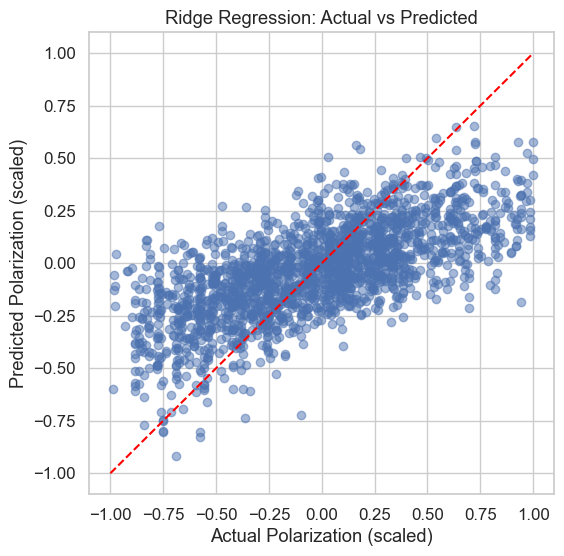

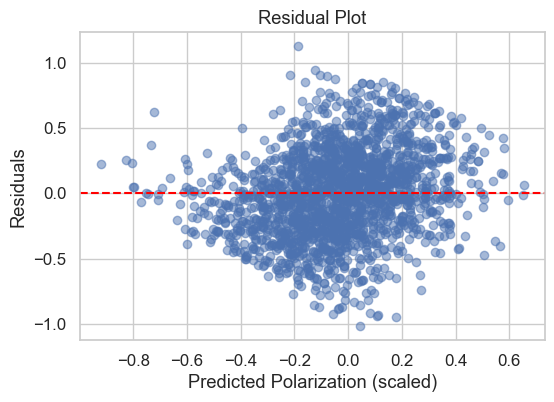

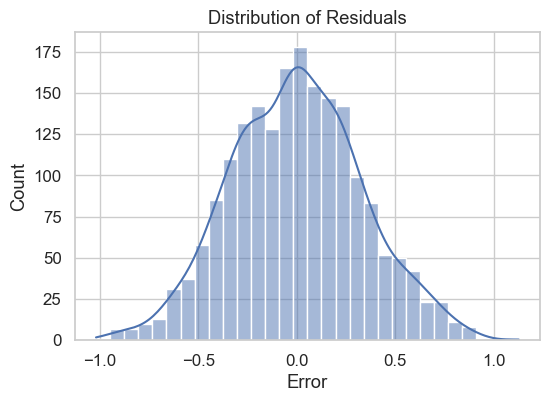

In [97]:
df_lin = merged_df.copy()
df_lin = df_lin.rename(columns={"political polarization score (central estimate)": "polarization score"})

y = np.array(df_lin["polarization score"]).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler.fit_transform(y)

df_lin["polarization scaled"] = y_scaled


X = tf_idf_matrix
y = df_lin['polarization scaled']
# y = df_lin['polarization score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lin = linear_model.Ridge(alpha=0.1)
model_lin.fit(X_train, y_train)

y_pred = model_lin.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", MSE)
print("Mean Absolute Error:", MAE)
print("R^2 Score:", r2)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Polarization (scaled)")
plt.ylabel("Predicted Polarization (scaled)")
plt.title("Ridge Regression: Actual vs Predicted")
plt.plot([-1, 1], [-1, 1], color='red', linestyle='--')  # perfect fit line
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Polarization (scaled)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# 3. Residual Distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.show()

## Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [82]:
X = tf_idf_matrix
y = merged_df['polarization label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.6412371134020619
              precision    recall  f1-score   support

     Neutral       0.60      0.95      0.74      1003
   Polarized       0.84      0.18      0.29       404
      Stable       0.81      0.42      0.55       533

    accuracy                           0.64      1940
   macro avg       0.75      0.51      0.53      1940
weighted avg       0.71      0.64      0.59      1940

